In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

MAX_EVENT_DISPLAY = 8 # custom number of neighbors to display
TEAM_NODE_A = 1740 # home team node to focus on and see neighbors of
FIG_SIZE = 5 # graph display size

In [183]:
df = pd.read_csv('data/processed/lol/events.csv')

In [313]:
selectedTeam = df.loc[df['u'] == TEAM_NODE_A, ['u', 'v', 'u_type', 'v_type', 'e_type']].head(MAX_EVENT_DISPLAY)
teamTypeDF = selectedTeam.drop_duplicates()
us = list(teamTypeDF[['u', 'u_type']].itertuples(index=False, name=None))
vs = list(teamTypeDF[['v', 'v_type']].itertuples(index=False, name=None))
nodesList = list(list(dict.fromkeys(us + vs)))
nodesList = list(map(lambda x: (x[0], {'Type': x[1]}), nodesList))
edgeUV = list(selectedTeam[['u', 'v']].itertuples(index=False, name=None))
edgesWithDups = selectedTeam.groupby(selectedTeam.columns.tolist(),as_index=False).size()
edgesWithDupsList = list(edgesWithDups[['u', 'v', 'e_type', 'size']].itertuples(index=False, name=None))
# Change arrow display direction if edge type is 3 (to show player joining team):
edgesWithDupsList = list(map(lambda x: (x[1] if x[2] == 3 else x[0], x[0] if x[2] == 3 else x[1], {'edge_type': x[2], 'weight': x[3]}), edgesWithDupsList))
edgesWithDupsList

[(1740, 1455, {'edge_type': 1, 'weight': 1}),
 (2627, 1740, {'edge_type': 3, 'weight': 1}),
 (1740, 2627, {'edge_type': 4, 'weight': 1}),
 (3493, 1740, {'edge_type': 3, 'weight': 1}),
 (5002, 1740, {'edge_type': 3, 'weight': 1}),
 (6746, 1740, {'edge_type': 3, 'weight': 1}),
 (9932, 1740, {'edge_type': 3, 'weight': 1}),
 (1740, 9932, {'edge_type': 4, 'weight': 1})]

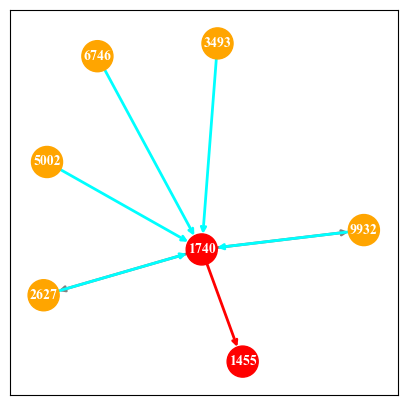

In [314]:
focusGraph = nx.DiGraph()

colorMap = {
    1: 'red',
    2: 'orange'
}

edgeColorMap = {
    1: 'red',
    2: 'green',
    3: 'cyan',
    4: 'gray'
}

# arrowMap = {
#     1: '<-',
#     2: '<-',
#     3: '->',
#     4: '-'
# }

focusGraph.add_nodes_from(nodesList)
focusGraph.add_edges_from(edgesWithDupsList)

colorValues = [colorMap.get(focusGraph.nodes[node]['Type'], 'blue') for node in focusGraph.nodes()]
edgeColorValues = [edgeColorMap.get(focusGraph.edges[edge]['edge_type'], 'black') for edge in focusGraph.edges()]

options = {
    'arrowstyle': '->',
    'arrowsize': 8
}

fig = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
nx.draw_networkx(
    focusGraph,
    # pos=pos,
    arrows=True,
    **options,
    with_labels=True,
    node_color=colorValues,
    edge_color=edgeColorValues,
    node_size=500,
    font_color="white",
    font_size=10,
    font_family="Times New Roman",
    font_weight="bold",
    width=2)

# plt.margins(0.2)
plt.show()